In [2]:
# https://github.com/DBraun/DawDreamer/wiki/Plugin-Processor

import dawdreamer as daw
import numpy as np
from scipy.io import wavfile
import librosa
from IPython.display import Audio

SAMPLE_RATE = 44100
BUFFER_SIZE = 128 # Parameters will undergo automation at this buffer/block size.
PPQN = 960 # Pulses per quarter note.
#SYNTH_PLUGIN = "/Library/Audio/Plug-Ins/VST3/Dexed.vst3"  # extensions: .dll, .vst3, .vst, .component
SYNTH_PLUGIN = "/Library/Audio/Plug-Ins/VST/TAL-NoiseMaker.vst"
#REVERB_PLUGIN = "/Library/Audio/Plug-Ins/Components/ValhallaFreqEcho.component"  # extensions: .dll, .vst3, .vst, .component
REVERB_PLUGIN = "/Library/Audio/Plug-Ins/VST3/RoughRider3.vst3"  # extensions: .dll, .vst3, .vst, .component

MIDI_PATH = "/Users/tsugumasayutani/Git/Dawdreamer_Test/data/C5_15sec.mid" # Midi読み込みパス
SAVE_MIDI_PATH = "/Users/tsugumasayutani/Git/Dawdreamer_Test/data/midi_output.mid" # Midi保存パス
DURATION = 10 # seconds

def make_sine(freq: float, duration: float, sr=SAMPLE_RATE) -> np.ndarray:
  """Return sine wave based on freq in Hz and duration in seconds"""
  N = int(duration * sr) # Number of samples 
  return np.sin(np.pi*2.*freq*np.arange(N)/sr)

In [34]:
synth_param_idx = 1

engine = daw.RenderEngine(SAMPLE_RATE, BUFFER_SIZE) # AudioProcessorのグラフを読み込み

# Make a processor and give it the unique name "my_synth", which we use later.
synth = engine.make_plugin_processor("my_synth", SYNTH_PLUGIN) # プラグインプロセッサを作成
assert synth.get_name() == "my_synth" # "my_synth"という名前かどうかを確認

# Plugins can show their UI.
#synth.open_editor()  # プラグインの UI エディターを開く??どういうこと？
synth.save_state('/Users/tsugumasayutani/Git/Dawdreamer_Test/data/state1') # プラグインの状態を保存。何を保存している??
# Next time, we can load_state without using open_editor.
synth.load_state('/Users/tsugumasayutani/Git/Dawdreamer_Test/data/state1')

# For some plugins, it's possible to load presets:
# Dexedは拡張子が違うので恐らくロードできない
#synth.load_preset('/Users/tsugumasayutani/Git/Dawdreamer_Test/preset.fxp')
#synth.load_vst3_preset('/Users/tsugumasayutani/Git/Dawdreamer_Test/preset.vstpreset')

# We'll set automation for our synth. Later we'll want to bake this automation into
# audio-rate data, so we must enable `record_automation`. If you don't intend to call
# `get_automation()` later, there's no need to do this:
synth.record_automation = True

# Get a list of dictionaries where each dictionary describes a controllable parameter.
#print(synth.get_parameters_description()) 
print("get_parameter_name : ",synth.get_parameter_name(synth_param_idx)) # For Serum, returns "A Pan" (oscillator A's panning)
print(synth.get_plugin_parameter_size()) # 湯谷が追加.Dexedで操作できるパラメータサイズが返ってくる

# Note that Plugin Processor parameters are between [0, 1], even "discrete" parameters.
# We can simply set a constant value.
synth.set_parameter(synth_param_idx, 0.1234) # idx=1のパラメータを0.1234にセット（静的な値をセット）
#synth.set_parameter(156, 1) # idx=1のパラメータを0.1234にセット（静的な値をセット）

get_parameter_name :  Master Volume
88


error: attempt to map invalid URI `/Library/Audio/Plug-Ins/VST/TAL-NoiseMaker.vst'
Attempting to load VST: /Library/Audio/Plug-Ins/VST/TAL-NoiseMaker.vst
Creating VST instance: TAL-NoiseMaker
Initialising VST: TAL-NoiseMaker (5.0.4.0)
Attempting to load VST: /Library/Audio/Plug-Ins/VST/TAL-NoiseMaker.vst
Creating VST instance: TAL-NoiseMaker
Initialising VST: TAL-NoiseMaker (5.0.4.0)


In [44]:
# The Plugin Processor can set automation with data at audio rate.
num_seconds = 10
synth.set_automation(synth_param_idx, 0.5+.5*make_sine(freq=.5, duration=num_seconds)) # 0.5 Hz sine wave remapped to [0, 1]

# Load a MIDI file and convert the timing to absolute seconds (beats=False).
# Changes to the Render Engine's BPM won't affect the timing. The kwargs below are defaults.
# MIDIファイルをロードしてタイミングを絶対時間に変換する。BPMの変更は影響しない。下記のkwargsはデフォルト値
synth.load_midi(MIDI_PATH, clear_previous=True, beats=False, all_events=True) # ファイルからMIDIを読み込み

# We can also add one note at a time, specifying a start time and duration, both in seconds
synth.add_midi_note(60, 127, 0.5, .25) # (MIDI note, velocity, start[s], duration)

True

In [42]:
# It's also possible to set automation in alignment with the tempo.
# Let's make a numpy array whose "sample rate" is PPQN. Suppose PPQN is 960.
# Each 960 values in the array correspond to a quarter note of time progressing.
# Let's make a parameter alternate between 0.25 and 0.75 four times per beat.
# Here, the second argument to `make_sine` actually represents a number of beats.
# PPQN = Pulses per quarter note
num_beats = 20
automation = make_sine(freq=8, duration=num_beats, sr=PPQN)
automation = 0.25+.5*(automation > 0).astype(np.float32) # automation>0 はbool値を返す. 0.25+0.5*True=0.75, 0.25+0.5*False=0.25. 疑似的な矩形波を生成
synth.set_automation(synth_param_idx, automation, ppqn=PPQN)

# Load a MIDI file and keep the timing in units of beats. Changes to the Render Engine's BPM
# will affect the timing.
synth.load_midi(MIDI_PATH, beats=True)

# With `beats=True`, we can use beats as the unit for the start time and duration.
# Rest for a beat and then play a note for a half beat.
# # 1拍休んでから半拍分音を鳴らす。
synth.add_midi_note(67, 127, 1, .5, beats=True)
synth.add_midi_note(67, 127, 3, 1, beats=True)

# For any processor type, we can get the number of inputs and outputs
# 任意のプロセッサタイプについて、入力と出力の数を求めることができる
print("synth num inputs: ", synth.get_num_input_channels())
print("synth num outputs: ", synth.get_num_output_channels())

synth num inputs:  2
synth num outputs:  2


In [45]:
reverb_processor = engine.make_plugin_processor("reverb", REVERB_PLUGIN)
#print(reverb_processor.get_parameters_description())
print(reverb_processor.get_plugin_parameter_size())

# (plugin_variable, input_plugin_variable)
graph = [
  (synth, []),  # synth takes no inputs, so we give an empty list.
  (reverb_processor, [synth.get_name()])  # hard-coding "my_synth" also works instead of get_name()
]

engine.load_graph(graph)
engine.render(5)  # Render 5 seconds of audio.
# engine.render(5, beats=True)  # Render 5 beats of audio.

audio = engine.get_audio()  # shaped (2, N samples) #stereo output
Audio(audio, rate=SAMPLE_RATE)

13


error: attempt to map invalid URI `/Library/Audio/Plug-Ins/VST3/RoughRider3.vst3'


In [46]:
# You can modify processors without recreating the graph.
#synth.load("/Users/tsugumasayutani/Git/Dawdreamer_Test/other_preset.fxp")

# After rendering, you can fetch PPQN-rate automation that has been baked into audio-rate data.
# Use a smaller buffer size to get more granularity in this data, otherwise there will be
# some "steppiness"/"nearest-lookup".
all_automation = synth.get_automation()  # a dictionary of all parameters at audio-rate.

# After rendering, you can save to MIDI with absolute times, in case the BPM affected it.
synth.save_midi(SAVE_MIDI_PATH)
# Even after a render, we can still modify our processors and re-render the graph.
# All of our MIDI is still loaded.
#synth.load_preset("/Users/tsugumasayutani/Git/Dawdreamer_Test/other_preset.fxp")
engine.render(DURATION)

#synth.clear_midi()
#synth.add_midi_note(65, 100, 1, .5, beats=True)

audio = engine.get_audio()  # shaped (2, N samples) #stereo output
# wavefile.write("path", sr, audio.T)  # write to disk
# audio.transpose() : [2,44100*10] -> [44100*10,2]に転置
wavfile.write('/Users/tsugumasayutani/Git/Dawdreamer_Test/data/PluginProcessor_tutorial.wav', SAMPLE_RATE, audio.transpose())
Audio(audio, rate=SAMPLE_RATE)

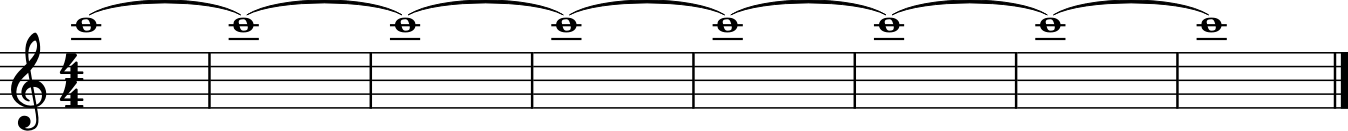

In [17]:
import music21 as m2

### 読み込み
s = m2.converter.parse(MIDI_PATH)
 ### 表示
s.show()

In [24]:
# MIDI Output is failed. I don't know why.
synth.load_midi(MIDI_PATH, beats=True)
synth.save_midi("/Users/tsugumasayutani/Git/Dawdreamer_Test/data/midi_output.mid")

## 使えるパラメータの確認

In [18]:

#print(synth.get_parameters_description()) 
print(synth.get_plugin_parameter_size()) # Dexedで操作できるパラメータサイズが返ってくる
len = synth.get_plugin_parameter_size()

for i in range(len):
    print(f'Parameter [{i}] : ', synth.get_parameter_name(i))

88
Parameter [0] :  -
Parameter [1] :  Master Volume
Parameter [2] :  Filter Type
Parameter [3] :  Filter Cutoff
Parameter [4] :  Filter Resonance
Parameter [5] :  Fitler Keyfollow
Parameter [6] :  Filter Contour
Parameter [7] :  Filter Attack
Parameter [8] :  Filter Decay
Parameter [9] :  Filter Sustain
Parameter [10] :  Filter Release
Parameter [11] :  Amp Attack
Parameter [12] :  Amp Decay
Parameter [13] :  Amp Sustain
Parameter [14] :  Amp Release
Parameter [15] :  Osc 1 Volume
Parameter [16] :  Osc 2 Volume
Parameter [17] :  Osc 3 Volume
Parameter [18] :  Osc Mastertune
Parameter [19] :  Osc 1 Tune
Parameter [20] :  Osc 2 Tune
Parameter [21] :  Osc 1 Fine Tune
Parameter [22] :  Osc 2 Fine Tune
Parameter [23] :  Osc 1 Waveform
Parameter [24] :  Osc 1 Waveform
Parameter [25] :  Osc Sync
Parameter [26] :  Lfo 1 Waveform
Parameter [27] :  Lfo 2 Waveform
Parameter [28] :  Lfo 1 Rate
Parameter [29] :  Lfo 2 Rate
Parameter [30] :  Lfo 1 Amount
Parameter [31] :  Lfo 2 Amount
Parameter [32

## その他

In [8]:
# 動作確認・勉強用
num_beats = 20
automation = make_sine(freq=4, duration=num_beats, sr=PPQN)
test = automation > 0
automation = 0.25+.5*(test).astype(np.float32)
print(test)
print(automation)

[False  True  True ... False False False]
[0.25 0.75 0.75 ... 0.25 0.25 0.25]
